In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, roc_auc_score, log_loss
from sklearn.model_selection import learning_curve


import matplotlib.pyplot as plt

import seaborn as sns

## References
- [Ensemble Modeling with Sklearn Pipelines](https://www.kaggle.com/code/bbusath5/ensemble-modeling-with-sklearn-pipelines)
- [PSS3E23 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense)

## Loading data & first inspect

Load data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
train.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [5]:
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [6]:
train["defects"] = train["defects"].astype(int)
train = train.drop(["id"], axis=1)

<AxesSubplot: >

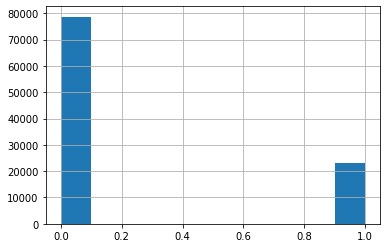

In [7]:
train["defects"].hist()

Obviously the data is strongly imbalanced. Let's see if there is any blank columns

In [8]:
train.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [9]:
train

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,10.0,2.0,1.0,1.0,28.0,122.98,0.15,6.60,18.63,811.70,...,7,0,1,0,11.0,8.0,16.0,12.0,3.0,0
101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,11268.27,...,23,0,2,0,18.0,20.0,67.0,40.0,9.0,0
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,0
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,0


In [10]:
train.cov()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
loc,2.981204e+03,328.507296,137.704468,210.421645,7.098282e+03,5.259920e+04,-2.120625,4.622120e+02,6.070546e+02,5.215968e+06,...,1.690765e+03,170.170005,233.742687,13.430331,135.274980,6.288570e+02,4.364253e+03,2.981471e+03,6.002446e+02,7.832493
v(g),3.285073e+02,62.423511,26.683911,34.568988,8.532999e+02,6.207609e+03,-0.306270,6.407545e+01,5.499454e+01,6.477181e+05,...,1.954433e+02,17.698578,23.284709,1.644139,20.793210,7.597980e+01,5.278773e+02,3.435135e+02,1.100815e+02,0.996263
ev(g),1.377045e+02,26.683911,21.448584,13.975924,3.095245e+02,2.164033e+03,-0.150887,2.339565e+01,1.699978e+01,2.428695e+05,...,6.828117e+01,8.000824,8.344121,0.761302,6.266169,2.334959e+01,1.912179e+02,1.238014e+02,5.171413e+01,0.503984
iv(g),2.104216e+02,34.568988,13.975924,30.631145,5.585933e+02,4.115396e+03,-0.161559,3.807018e+01,4.047687e+01,4.158684e+05,...,1.358541e+02,11.032605,15.048840,0.987087,14.152912,5.505085e+01,3.422788e+02,2.250152e+02,5.965617e+01,0.569123
n,7.098282e+03,853.299900,309.524495,558.593270,2.929136e+04,2.019177e+05,-5.145332,1.953495e+03,2.837701e+03,1.857612e+07,...,6.014145e+03,572.140018,846.927037,44.948090,713.917650,2.532041e+03,1.723603e+04,1.169424e+04,1.544180e+03,18.492169
v,5.259920e+04,6207.608687,2164.033061,4115.396184,2.019177e+05,1.614911e+06,-32.320179,1.342522e+04,1.955926e+04,1.410272e+08,...,4.404347e+04,3990.281876,5963.581860,307.268173,4668.458534,1.834094e+04,1.244027e+05,8.583909e+04,1.114832e+04,122.994639
l,-2.120625e+00,-0.306270,-0.150887,-0.161559,-5.145332e+00,-3.232018e+01,0.010019,-6.025811e-01,-3.713196e-01,-1.750436e+03,...,-1.117655e+00,-0.111061,-0.184524,-0.012546,-0.269863,-5.128736e-01,-3.081259e+00,-2.085079e+00,-6.004132e-01,-0.010612
d,4.622120e+02,64.075449,23.395645,38.070184,1.953495e+03,1.342522e+04,-0.602581,1.994113e+02,1.663547e+02,1.268258e+06,...,4.238921e+02,40.559617,60.952750,3.782966,74.608739,1.761791e+02,1.193182e+03,7.944605e+02,1.170595e+02,1.430341
i,6.070546e+02,54.994536,16.999783,40.476870,2.837701e+03,1.955926e+04,-0.371320,1.663547e+02,5.224307e+02,1.246418e+06,...,5.964661e+02,58.797525,95.456421,4.889438,81.400527,3.316871e+02,1.677491e+03,1.212932e+03,1.034191e+02,1.995932
e,5.215968e+06,647718.131508,242869.478553,415868.429144,1.857612e+07,1.410272e+08,-1750.435740,1.268258e+06,1.246418e+06,3.631746e+10,...,4.260645e+06,370060.976706,530640.263844,23719.991771,354784.169330,1.428119e+06,1.153513e+07,7.746453e+06,1.173126e+06,7608.780583


Next, let's check the distribution of variables.

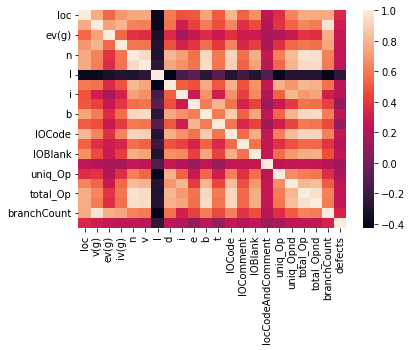

In [11]:
sns.heatmap(train.corr())
plt.show()

And distribution of every variables

In [12]:
def plot_distribution(df):
    _, axis = plt.subplots(7, 3, figsize=(12, 12))
    
    for col, ax in zip(df.columns, axis.ravel()):
        if df[col].dtype == float:
            ax.hist(df[col], bins=100, color="orange")
        else:
            vc = df[col].value_counts()
            ax.bar(vc.index, vc, color="orange")
        ax.set_xlabel(col)
    
    plt.tight_layout()
    plt.suptitle("Feature distributions", y=1.02, fontsize=20)
    plt.show()

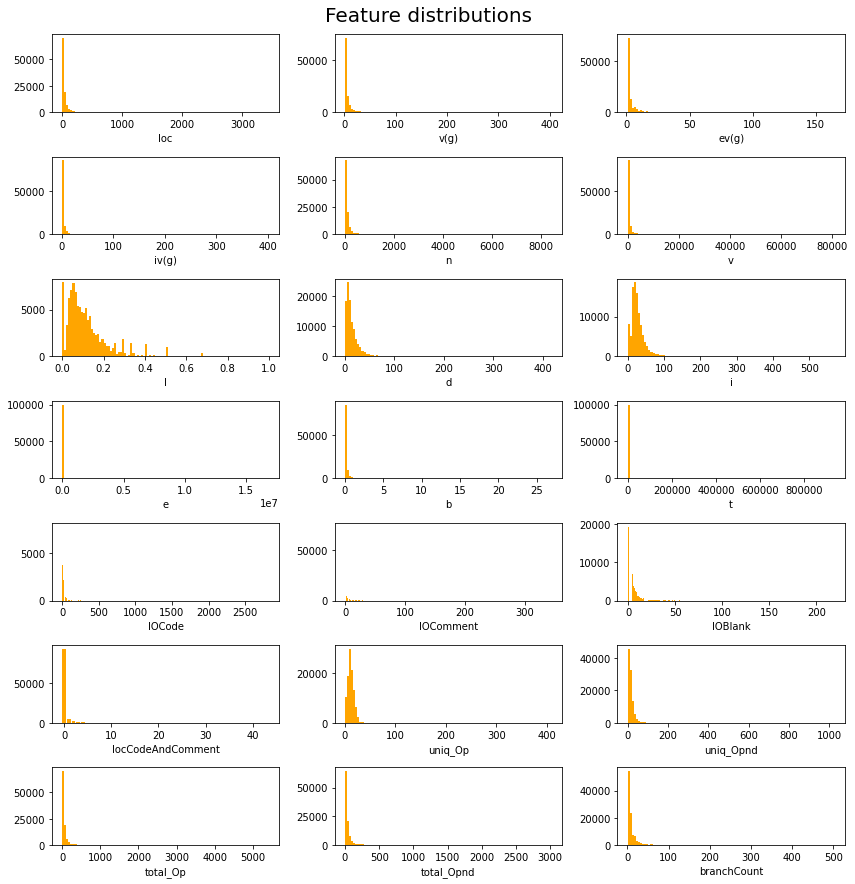

In [13]:
plot_distribution(train)

## Building training pipeline

In [14]:
transform = FunctionTransformer(np.log1p)

In [15]:
estimators = [
    ("logistic", LogisticRegression(solver="liblinear", penalty="l2")),
    # ("lasso", LogisticRegression(solver="liblinear", penalty="l1")),
    ("elasticnet", SGDClassifier(loss="log_loss", penalty="elasticnet")),
    ("random_forest", RandomForestClassifier()),
    ("gradient_boosting", GradientBoostingClassifier()),
    # ("svc", SVC(kernel="linear", probability=True)),
    ("deep_nn", MLPClassifier()),
]

In [16]:
X = train.drop(["defects"], axis=1)
y = train["defects"]

Define pipelines and training 

In [17]:
pipes = {}

for model in estimators:
    print(f"Fitting {model[0]}")
    
    pipe = Pipeline(steps=[
        ("transform", transform),
        ("poly_features", PolynomialFeatures(2, include_bias=False)),
        ("std_scaler", StandardScaler()),
        model
    ])
    pipe.fit(X, y)
    pipes[pipe.steps[3][0]] = pipe

Fitting logistic
Fitting elasticnet
Fitting random_forest
Fitting gradient_boosting
Fitting deep_nn


Plotting AUC score for the training

In [18]:
_metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

In [19]:
estimator_names = [model[0] for model in estimators]

In [20]:
def plot_estimators(estimators=estimator_names, 
                   n_splits=5,
                   metrics=["auc", "log_loss"]):
    metrics = {
        key: _metrics[key] for key in metrics
    }
    
    scorer, labels = [], []
    
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe = pipes[pipe_name]
            
            print(pipe)
            
            labels.append(pipe_name)
            
            kf = KFold(n_splits)
            
            model_score = cross_validate(pipe, X, y, scoring=metrics, cv=kf)
            
            scorer.append(model_score)
    
    score_lists = {}
    
    for metric in metrics:
        score_lists[metric] = [score[f"test_{metric}"] for score in scorer]
        
    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot = sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [21]:
metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('logistic', LogisticRegression(solver='liblinear'))])
Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('elasticnet',
                 SGDClassifier(loss='log_loss', penalty='elasticnet'))])
Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('random_forest', RandomForestClassifier())])
Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                (

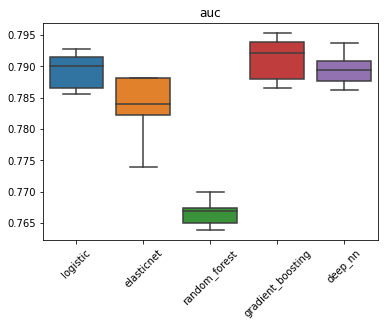

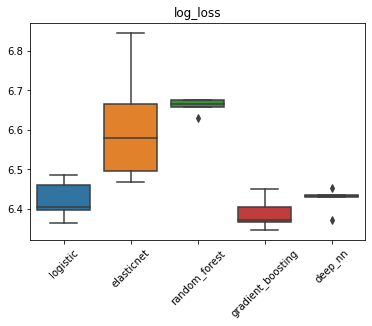

In [22]:
plot_estimators()

## Hyperparam tuning

In [29]:
def tune_param(model, param_grid, refit="auc", chart=None, X=X, y=y, cv=5):
    param_grid = {
        f"{model}__{key}" : param_grid[key]
        for key in param_grid.keys()
    }
    
    grid_cv = GridSearchCV(
        pipes[model],
        param_grid,
        scoring=metrics,
        refit=refit,
        return_train_score=True,
        cv=cv,
        n_jobs=4,
        verbose=3
    )
    
    grid_cv.fit(X, y)
    
    print(f"Best score: { grid_cv.best_score_ }")
    print(f"Best params: { grid_cv.best_params_ }")
    
    results = pd.DataFrame(grid_cv.cv_results_)
    
    if "line" in chart:
        for i, param in enumerate(param_grid.keys()):
            graph_data = results[[
                f"param_{param}",
                f"mean_test_{refit}",
                f"mean_train_{refit}"
            ]]
            
            graph_data = graph_data.rename(columns = {
                f"mean_test_{refit}" : "test",
                f"mean_train_{refit}" : "train",
            })
            
            graph_data = graph_data.melt(f"param_{param}", var_name="type", value_name=refit)
            plt.figure(i)
            plot = sns.lineplot(x=f"param_{param}", y=refit, hue="type", data=graph_data)
    
    if "heatmap" in chart:
        param1 = list(param_grid.keys())[0]
        param2 = list(param_grid.keys())[1]
        
        graph_data = results[[
            f"param_{param1}",
            f"param_{param2}",
            f"mean_test_{refit}"
        ]]
        
        graph_data = graph_data.pivot(index=f"param_{param1}", 
                                      columns=f"param_{param2}", 
                                     values=f"mean_test_{refit}")
        
        sns.heatmap(graph_data, annot=True, xticklabels=True, yticklabels=True).set(
            xlabel=param2,
            ylabel=param1
        )

### Tuning Random Forest

In [24]:
pipes['random_forest'].named_steps['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_grid = {'n_estimators': [100, 200, 300, 400, 500]}
tune_param('random_forest',param_grid,chart='line')

In [ ]:
# Set n_estimator variable


In [ ]:
param_grid = {'max_depth': [3, 8, 13, 18]}
tune_param('random_forest', param_grid, chart='line')

In [ ]:
# Set max_depth variable


In [ ]:
param_grid = {'max_leaf_nodes': [5, 10, 15, 20, 25]}
tune_param('random_forest', param_grid, chart='line')

In [ ]:
# Set max_leaf_nodes variable

### Tuning Gradient Boosting

In [30]:
pipes['gradient_boosting'].named_steps['gradient_boosting'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [32]:
param_grid = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]}
tune_param('gradient_boosting', param_grid, chart='line')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END gradient_boosting__n_estimators=1; auc: (train=0.778, test=0.778) log_loss: (train=7.828, test=7.828) total time=   4.4s
[CV 2/5] END gradient_boosting__n_estimators=1; auc: (train=0.777, test=0.770) log_loss: (train=7.828, test=7.828) total time=   4.3s
[CV 3/5] END gradient_boosting__n_estimators=1; auc: (train=0.779, test=0.780) log_loss: (train=7.828, test=7.828) total time=   3.8s
[CV 4/5] END gradient_boosting__n_estimators=1; auc: (train=0.780, test=0.776) log_loss: (train=7.828, test=7.827) total time=   3.9s
[CV 5/5] END gradient_boosting__n_estimators=1; auc: (train=0.780, test=0.775) log_loss: (train=7.828, test=7.829) total time=   3.8s
[CV 1/5] END gradient_boosting__n_estimators=2; auc: (train=0.784, test=0.786) log_loss: (train=7.828, test=7.828) total time=   7.0s
[CV 2/5] END gradient_boosting__n_estimators=2; auc: (train=0.779, test=0.773) log_loss: (train=7.828, test=7.828) total time=   7.1s
[C

KeyboardInterrupt: 

In [ ]:
# Set n_estimators

In [33]:
param_grid = {'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]}
tune_param('gradient_boosting', param_grid, chart='line')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

### Tuning SVC

In [ ]:
# TODO

### Tuning linear models

In [34]:
# Logistic regression
pipes["logistic"].set_params(**{
    "logistic__C": 0.1,
    "logistic__tol": .001
})

Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=0.1, solver='liblinear', tol=0.001))])

In [35]:
# Elastic net
pipes["elasticnet"].set_params(**{
    "elasticnet__alpha": 0.01,
    "elasticnet__tol": 0.001
})

Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('elasticnet',
                 SGDClassifier(alpha=0.01, loss='log_loss',
                               penalty='elasticnet'))])

### Learning curves

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [37]:
dummy_transform = transform
X_dummy = dummy_transform.fit_transform(X)

Plotting logistic
Plotting elasticnet
Plotting gradient_boosting
Plotting deep_nn


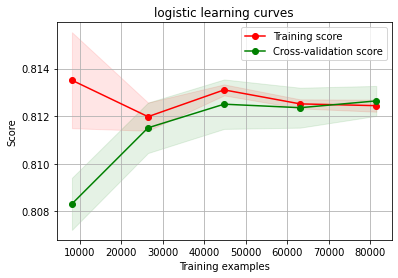

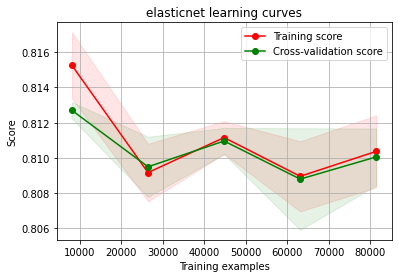

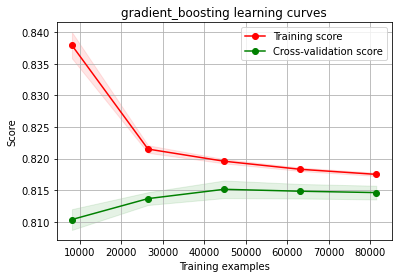

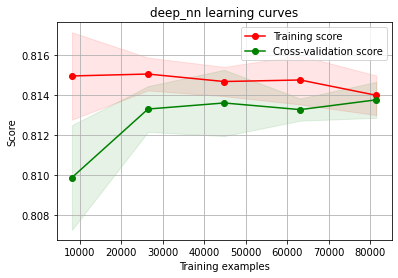

In [45]:
to_plot = ["logistic", "elasticnet", "gradient_boosting", "deep_nn"]

for name in pipes.keys():
    if name in to_plot:
        print(f"Plotting {name}")
        g = plot_learning_curve(
            pipes[name].named_steps[name],
            f"{name} learning curves",
            X_dummy,
            y,
            cv=KFold(5),
            n_jobs=4
        )

### Tree-based feature importance (todo)

In [ ]:
# TODO

### Estimator prediction correlation

<AxesSubplot: >

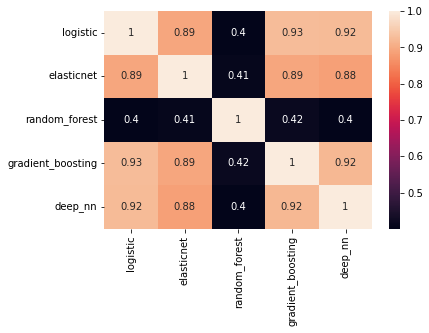

In [46]:
ensemble_results = pd.DataFrame()

for name, pipe in pipes.items():
    ensemble_results[name] = pipe.predict(X)
    
sns.heatmap(ensemble_results.corr(), annot=True)

# Predicting the test set

In [47]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

In [51]:
voting_estimators = [
    (pipes[name].steps[3][0], clone(pipes[name].steps[3][1])) for name in to_plot
]

In [52]:
voting_estimators

[('logistic', LogisticRegression(C=0.1, solver='liblinear', tol=0.001)),
 ('elasticnet',
  SGDClassifier(alpha=0.01, loss='log_loss', penalty='elasticnet')),
 ('gradient_boosting', GradientBoostingClassifier()),
 ('deep_nn', MLPClassifier())]

In [57]:
vote = Pipeline([
    ("transform", transform),
    ("poly_features", PolynomialFeatures(2, include_bias=False)),
    ("std_scaler", StandardScaler()),
    ("voter", VotingClassifier(voting_estimators, 
                               voting="soft", 
                               n_jobs=4))
], verbose=True)

In [58]:
vote.fit(X, y)

[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.0s
[Pipeline] ..... (step 2 of 4) Processing poly_features, total=   0.3s
[Pipeline] ........ (step 3 of 4) Processing std_scaler, total=   0.4s
[Pipeline] ............. (step 4 of 4) Processing voter, total= 7.5min


Pipeline(steps=[('transform', FunctionTransformer(func=<ufunc 'log1p'>)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('voter',
                 VotingClassifier(estimators=[('logistic',
                                               LogisticRegression(C=0.1,
                                                                  solver='liblinear',
                                                                  tol=0.001)),
                                              ('elasticnet',
                                               SGDClassifier(alpha=0.01,
                                                             loss='log_loss',
                                                             penalty='elasticnet')),
                                              ('gradient_boosting',
                                               GradientBoostingClassifier()),
                                              ('deep_nn', MLPClassifier())],
                                  n_jobs=4, voting='soft'))],
         verbose=True)

In [59]:
test_data = test.drop(["id"], axis=1)

In [60]:

pred_probs = vote.predict_proba(test_data)[:, 1]

In [61]:
pred_probs

array([0.25205546, 0.18709612, 0.66658823, ..., 0.18033034, 0.09910194,
       0.70915575])

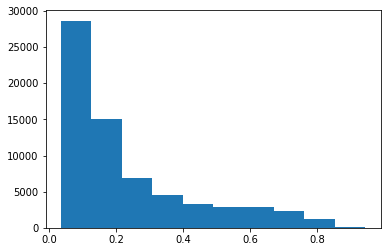

In [62]:
plt.hist(pred_probs)
plt.show()

In [63]:
submission_df = pd.DataFrame({
    "id": test["id"],
    "defects": pred_probs
})

In [69]:
submission_df

,id,defects
0,101763,0.252055
1,101764,0.187096
2,101765,0.666588
3,101766,0.481151
4,101767,0.150004
...,...,...
67837,169600,0.288878
67838,169601,0.138037
67839,169602,0.180330
67840,169603,0.099102


In [72]:
submission_df.to_csv("submission_new.csv", index=False)

In [68]:
!more submission.csv

^C
